In [1]:
import os
import sys
import argparse
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(r"C:\Users\dg\Documents\python\diffusion-net\src")
import diffusion_net
from diffusion_net.utils import toNP
from ga_dataset import GaDataset, make_model

C:\Users\dg\.conda\envs\diffnet4\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
device = torch.device('cuda:0')
dtype = torch.float32

In [14]:
data_file = r"C:\Users\dg\Documents\python\diffusion-net\experiments\regression_0\data\run00032_data.hdf"
train_dataset, test_dataset = GaDataset.load_lineages(
    data_file=Path(data_file), k_eig=128, channel=17)

train_loader = DataLoader(train_dataset,  batch_size=None, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=None)

Pre-calculating operators


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 955/955 [00:04<00:00, 233.83it/s]


In [15]:
model = make_model(3)
model.load_state_dict(torch.load(r"C:\Users\dg\Documents\python\diffusion-net\experiments\regression_0\data\trained.pth"))
# model.eval()
_ = model.to(device)

In [16]:
def get_predictions(input_features, loader):
    all_preds = []
    
    model.eval()
    with torch.no_grad():
        for data in tqdm(loader):
            # Get data
            verts, faces, frames, mass, L, evals, evecs, gradX, gradY, labels = data

            # Move to device
            verts = verts.to(device)
            faces = faces.to(device)
            frames = frames.to(device)
            mass = mass.to(device)
            L = L.to(device)
            evals = evals.to(device)
            evecs = evecs.to(device)
            gradX = gradX.to(device)
            gradY = gradY.to(device)
            labels = labels.to(device)
            
            # Construct features
            if input_features == 'xyz':
                features = verts
            elif input_features == 'hks':
                features = diffusion_net.geometry.compute_hks_autoscale(evals, evecs, 16)

            # Apply the model
            preds = model(features, mass, L=L, evals=evals, evecs=evecs, gradX=gradX, gradY=gradY, faces=faces)
            all_preds.append(preds.item())
        
    return all_preds    

In [ ]:
train_preds = get_predictions('xyz', train_loader)
plt.plot(train_dataset.df.response.values, train_preds, 'k.')

In [19]:
from numpy import array, sqrt
((array(preds) - train_dataset.df.response.values) ** 2).mean()

8.834586961311356

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 495/495 [00:09<00:00, 50.23it/s]


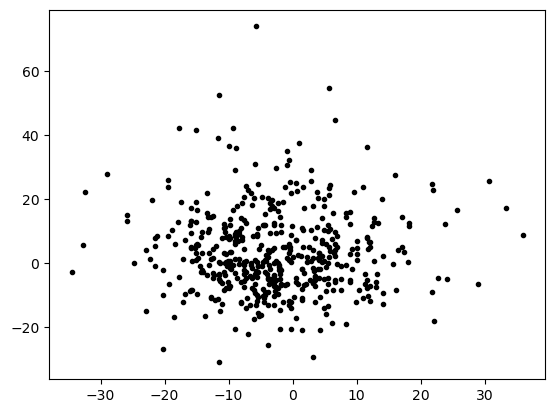

In [22]:
test_preds = get_predictions('xyz', test_loader)
plt.plot(test_dataset.df.response.values, test_preds, 'k.')